In [38]:
# The path to the local git repo for Indic NLP library
INDIC_NLP_LIB_HOME=r"/Users/mayureshnene/Desktop/indic_nlp_library"

# The path to the local git repo for Indic NLP Resources
INDIC_NLP_RESOURCES=r"/Users/mayureshnene/Desktop/indic_nlp_resources"

import sys
import pandas as pd
import numpy as np
import warnings
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

from indicnlp import common
from indicnlp import loader
from indicnlp.tokenize import indic_tokenize
from indicnlp.tokenize import indic_tokenize 
from indicnlp.morph import unsupervised_morph 
from indicnlp import common

sys.path.append(r'{}'.format(INDIC_NLP_LIB_HOME))

common.set_resources_path(INDIC_NLP_RESOURCES)

loader.load()


In [39]:
training_dataset = pd.read_csv("/Users/mayureshnene/Desktop/MOLD/Mold/MOLD_Training2.csv")
training_dataset.head()
training_dataset.dropna()
training_dataset['subtask_c'].fillna("NULL")

0       NULL
1       NULL
2       NULL
3       NULL
4       NULL
        ... 
2692     OTH
2693     IND
2694     IND
2695    NULL
2696     GRP
Name: subtask_c, Length: 2697, dtype: object

In [40]:
tweets = training_dataset["tweet"]
tweets

0        पूर्व लडाखमधील मुखपरी येथे प्रत्यक्ष ताबारेषे...
1        कोणत्याही succesful रिलेशनशिप मध्ये सुंदर दिस...
2       भारत 15 ऑगस्ट 1947 ला स्वतंत्र झाला आणि त्यानं...
3       स्वत ला हवा तसा बाइट किंवा प्रतिक्रिया घेण्यास...
4       5 व्या नंबरची अर्थव्यवस्था आहे भारताची जगात 20...
                              ...                        
2692    @USER अहो त्याचा रोजगार गेला ना तो महिन्याला ४...
2693    @USER चंपा जी ब्लॉक करुन जाणारे भुरटे धड निवडण...
2694    चंपा जी ब्लॉक करुन जाणारे भुरटे धड निवडणून येत...
2695                                            @USER मंद
2696    केली का काय होते ते सांगा या झमन्याला आणि चेंब...
Name: tweet, Length: 2697, dtype: object

In [41]:
level_A = training_dataset[["subtask_a"]]
level_B = training_dataset.query("subtask_a == 'Offensive'")[["subtask_b"]]
level_C = training_dataset.query("subtask_b == 'TIN'")[["subtask_c"]]

In [42]:
stopwords_file = open("/Users/mayureshnene/Desktop/MOLD/Mold/stopwords.txt")
stopwords = stopwords_file.read().splitlines()
print(stopwords)

['अधिक ', 'अनेक ', 'अशी ', 'असलयाचे', 'असलेल्या', 'असा', 'असून', 'असे', 'आज', 'आणि', 'आता', 'आपल्या', 'आला', 'आली', 'आले', 'आहे', 'आहेत', 'एक', 'एका', 'कमी', 'करणयात', 'करून', 'का', 'काम', 'काय', 'काही', 'किवा', 'की', 'केला', 'केली', 'केले', 'कोटी', 'गेल्या', 'घेऊन', 'जात', 'झाला', 'झाली', 'झाले', 'झालेल्या', 'टा', 'डॉ', 'तर', 'तरी', 'तसेच', 'ता', 'ती', 'तीन', 'ते', 'तो', 'त्या', 'त्याचा', 'त्याची', 'त्याच्या', 'त्याना', 'त्यानी', 'त्यामुळे', 'त्री', 'दिली', 'दोन', 'न', 'नाही', 'निर्ण्य', 'पण', 'पम', 'परयतन', 'पाटील', 'म', 'मात्र', 'माहिती', 'मी', 'मुबी', 'म्हणजे', 'म्हणाले', 'म्हणून', 'या', 'याचा', 'याची', 'याच्या', 'याना', 'यानी', 'येणार', 'येत', 'येथील', 'येथे', 'लाख', 'व', 'व्यकत', 'सर्व', 'सागित्ले', 'सुरू', 'हजार', 'हा', 'ही', 'हे', 'होणार', 'होत', 'होता', 'होती', 'होते']


In [43]:
def clean(tweet):
    removal_list = ['URL','\'ve','n\'t','\'s','\'m','!']
    for element in removal_list:
        tweet = str(tweet).replace(element,'')
    
    return tweet

In [44]:
# for tweet in tweets:
#     tweet = remove_noise(str(tweet))
iterator_map = map(clean,tweets)
tweets = list(iterator_map)

In [45]:
  

collective_tweets = copy.deepcopy(training_dataset)

In [46]:


analyzer=unsupervised_morph.UnsupervisedMorphAnalyzer('mr')


In [47]:
def tokenize(tweet):
    return indic_tokenize.trivial_tokenize(tweet)

def morph(tweet):
    analyzed_tokens=analyzer.morph_analyze_document(str(tweet).split(' '))
    return analyzed_tokens

In [48]:
tqdm.pandas(desc="Tokenize..")
#all_tweets["tokens"] = all_tweets['tweet'].progress_apply(tokenize)
collective_tweets["tokens"] = collective_tweets['tweet'].progress_apply(morph)

Tokenize..: 100%|██████████| 2697/2697 [00:00<00:00, 2975.33it/s]


In [49]:
vector = collective_tweets["tokens"].tolist()

In [50]:
def tfid_vectorizer(vector):
	## Creates and stores an instance of the TfidfVectorizer class. This will be used further to extract our data as tf-idf features.
	vectorizer = TfidfVectorizer()
	untokenized_data =[' '.join(tweet) for tweet in tqdm(vector, "Vectorizing...")]
	vectorizer = vectorizer.fit(untokenized_data)
	vectors = vectorizer.transform(untokenized_data).toarray()
	return vectors

def get_vectors(vectors, labels, keyword):
	'''
	Returns a matrix for vectors. Zips vectors and labels IF and only if length of vector list is the same as length of the labels list. 
	Else, the function gets terminated.
	@param vectors These are the vectors for a given label.
	@param labels These are the label values for the given label.
	@param keyword which is the label to annotate for.
	'''
	if len(vectors) != len(labels):
		print("Unmatching sizes!")
		return
	
	## Stores a new list to append the zipped vectors and labels into.
	result = list()
	for vector, label in zip(vectors, labels):
		if label == keyword:
			result.append(vector)
	return result

In [51]:
vectors_level_A = tfid_vectorizer(vector)
labels_level_a = level_A['subtask_a'].values.tolist()
vectors_level_B = get_vectors(vectors_level_A, labels_level_a, "Offensive") 

labels_level_b = level_B['subtask_b'].values.tolist() 

## Numerical Vectors C
vectors_level_c = get_vectors(vectors_level_B, labels_level_b, "TIN") 

##Subtask C Labels
labels_level_c = level_C['subtask_c'].values.tolist() 

Vectorizing...: 100%|██████████| 2697/2697 [00:00<00:00, 459446.73it/s]


In [69]:
train_vectors_level_A, train_labels_level_A,= vectors_level_A[1:2660], labels_level_a[1:2660]
test_vectors_level_A, test_labels_level_A = vectors_level_A[2661:3135], labels_level_a[2661:3135]
## Extracting names of labels and storing them in a variable
classNames = np.unique(test_labels_level_A)

print("Training begins on Level A classification...")
warnings.filterwarnings(action='ignore')

## Creating an object of SVC
classifiersvc = SVC()
classifiermnb = MultinomialNB()
classifiersgd = SGDClassifier()
classifiermlp = MLP()

classifiersvc.fit(train_vectors_level_A, train_labels_level_A)
classifiermnb.fit(train_vectors_level_A, train_labels_level_A)
classifiersgd.fit(train_vectors_level_A, train_labels_level_A)
classifiermlp.fit(train_vectors_level_A, train_labels_level_A)

accuracy = accuracy_score(train_labels_level_A, classifiersvc.predict(train_vectors_level_A))
print("Training Accuracy:", accuracy)


test_predictions_svc = classifiersvc.predict(test_vectors_level_A)
test_predictions_mnb = classifiermnb.predict(test_vectors_level_A)
test_predictions_sgd = classifiersgd.predict(test_vectors_level_A)
test_predictions_mlp = classifiermlp.predict(test_vectors_level_A)


test_predictions_svc = classifiersvc.predict(test_vectors_level_A)
test_predictions_mnb = classifiermnb.predict(test_vectors_level_A)
test_predictions_sgd = classifiersgd.predict(test_vectors_level_A)
test_predictions_mlp = classifiermlp.predict(test_vectors_level_A)


preds_A = pd.DataFrame(columns = ['SVC_A', 'MNB_A', 'SGD_A','MLP_A'])
label_name = ['SVC_A', 'MNB_A','SGD_A','MLP_A']
preds = [test_predictions_svc, test_predictions_mnb, test_predictions_sgd, test_predictions_mlp]

i = 0
for label in label_name:
    preds_A[label] = test_predictions[i]
    i += 1



Training begins on Level A classification...
Training Accuracy: 0.9368183527641971


,SVC_Level_A
0,not offensive
1,not offensive
2,not offensive
3,not offensive
4,not offensive
5,not offensive
6,not offensive
7,not offensive
8,not offensive
9,Offensive


Training begins on Level B classification...
Training complete....
calculating accuracy....
Training Accuracy: 0.8808219178082192
Test Accuracy: 0.7131147540983607
Confusion Matrix:
[[163   3   0]
 [ 61  11   0]
 [  6   0   0]]
              precision    recall  f1-score   support

         TIN       0.71      0.98      0.82       166
         UNT       0.79      0.15      0.26        72
         nan       0.00      0.00      0.00         6

    accuracy                           0.71       244
   macro avg       0.50      0.38      0.36       244
weighted avg       0.71      0.71      0.64       244



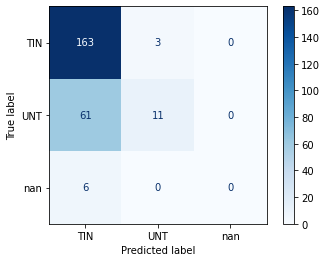

Training begins on Level C classification...
Training complete....
calculating accuracy....
Training Accuracy: 0.8778004073319755
Test Accuracy: 0.725609756097561
Confusion Matrix:
[[  5  32   0]
 [  2 114   0]
 [  1  10   0]]
              precision    recall  f1-score   support

         GRP       0.62      0.14      0.22        37
         IND       0.73      0.98      0.84       116
         OTH       0.00      0.00      0.00        11

    accuracy                           0.73       164
   macro avg       0.45      0.37      0.35       164
weighted avg       0.66      0.73      0.64       164



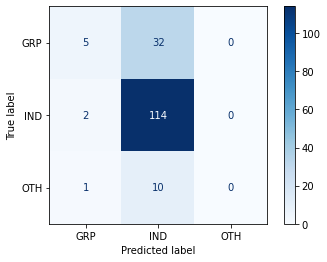

In [70]:
## Split into Train and Test vectors using the vectors of level A and Labels of level B with a training size of 0.75.
train_vectors_level_B, test_vectors_level_B, train_labels_level_B, test_labels_level_B = train_test_split(vectors_level_B[:], labels_level_b[:], train_size=0.75)

## Extracting names of labels and storing them in a variable
classNames = np.unique(test_labels_level_B)
print("Training begins on Level B classification...")
warnings.filterwarnings(action='ignore')

## Creating an object of SVC
classifiersvc = SVC()
classifiermnb = MultinomialNB()
classifiersgd = SGDClassifier()
classifiermlp = MLP()

classifiersvc.fit(train_vectors_level_B, train_labels_level_B)
classifiermnb.fit(train_vectors_level_B, train_labels_level_B)
classifiersgd.fit(train_vectors_level_B, train_labels_level_B)
classifiermlp.fit(train_vectors_level_B, train_labels_level_B)

print("Training complete....")


print("calculating accuracy....")
## Training accuracy has been calculated
accuracy = accuracy_score(train_labels_level_B, classifiersvc.predict(train_vectors_level_B))
print("Training Accuracy:", accuracy)

## predictions are obtained on the testing data set
test_predictionsB = classifiersvc.predict(test_vectors_level_B)

## Testing accuracy has been calculated
accuracy = accuracy_score(test_labels_level_B, test_predictionsB)
print("Test Accuracy:", accuracy)

print("Confusion Matrix:")
## confusion matrix has been obtained for level A classification
matrix_level_B = confusion_matrix(test_labels_level_B, test_predictionsB)
print(matrix_level_B)
## Obtaining classification report for the test data set
print(classification_report(test_labels_level_B,test_predictionsB))

## Plotting confusion matrix for better visualization
plottedCM_Level_B = plot_confusion_matrix(classifiersvc, test_vectors_level_B, test_labels_level_B, display_labels=classNames, cmap=plt.cm.Blues)
plt.show()





## Split into Train and Test vectors using the vectors of level A and Labels of level B with a training size of 0.75.
train_vectors_level_C, test_vectors_level_C, train_labels_level_C, test_labels_level_C = train_test_split(vectors_level_c[:], labels_level_c[:], train_size=0.75)

## Extracting names of labels and storing them in a variable
classNames = np.unique(test_labels_level_C)
print("Training begins on Level C classification...")
warnings.filterwarnings(action='ignore')

## Creating an object of SVC
classifiersvc = SVC()

## Creating a parameter grid using the arguments SVC uses for hyper parameter tuning using GridSearchCV
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]}]


# Model fit
classifiersvc.fit(train_vectors_level_C, train_labels_level_C)

print("Training complete....")


print("calculating accuracy....")
## Training accuracy has been calculated
accuracy = accuracy_score(train_labels_level_C, classifiersvc.predict(train_vectors_level_C))
print("Training Accuracy:", accuracy)

## predictions are obtained on the testing data set
test_predictionsC = classifiersvc.predict(test_vectors_level_C)

## Testing accuracy has been calculated
accuracy = accuracy_score(test_labels_level_C, test_predictionsC)
print("Test Accuracy:", accuracy)


print("Confusion Matrix:")
## confusion matrix has been obtained for level A classification
matrix_level_C = confusion_matrix(test_labels_level_C, test_predictionsC)
print(matrix_level_C)
## Obtaining classification report for the test data set
print(classification_report(test_labels_level_C,test_predictionsC))

## plotting confusion matrix for better visualization
plottedCM = plot_confusion_matrix(classifiersvc, test_vectors_level_C, test_labels_level_C, display_labels=classNames, cmap=plt.cm.Blues)
plt.show()

In [ ]:
test_predictions_svc = classifiersvc.predict(test_vectors_level_B)
test_predictions_mnb = classifiermnb.predict(test_vectors_level_B)
test_predictions_sgd = classifiersgd.predict(test_vectors_level_B)
test_predictions_mlp = classifiermlp.predict(test_vectors_level_B)


preds_B = pd.DataFrame(columns = ['SVC_B', 'MNB_B', 'SGD_B','MLP_B'])
label_name = ['SVC_B', 'MNB_B','SGD_B','MLP_B']
preds = [test_predictions_svc, test_predictions_mnb, test_predictions_sgd, test_predictions_mlp]

i = 0
for label in label_name:
    preds_B[label] = test_predictions[i]
    i += 1

,SVC_Level_B
0,TIN
1,TIN
2,TIN
3,TIN
4,TIN
...,...
239,TIN
240,TIN
241,TIN
242,TIN


In [72]:
test_predictions_svc = classifiersvc.predict(test_vectors_level_C)
test_predictions_mnb = classifiermnb.predict(test_vectors_level_C)
test_predictions_sgd = classifiersgd.predict(test_vectors_level_C)
test_predictions_mlp = classifiermlp.predict(test_vectors_level_C)


preds_C = pd.DataFrame(columns = ['SVC_C', 'MNB_C', 'SGD_C','MLP_C'])
label_name = ['SVC_C', 'MNB_C','SGD_C','MLP_C']
preds = [test_predictions_svc, test_predictions_mnb, test_predictions_sgd, test_predictions_mlp]

i = 0
for label in label_name:
    preds_C[label] = test_predictions[i]
    i += 1


,SVC_Level_C
0,IND
1,IND
2,IND
3,IND
4,IND
...,...
159,IND
160,IND
161,GRP
162,IND


In [76]:
#final_df = pd.DataFrame()
final_df = pd.concat([preds_A, preds_B, preds_C], ignore_index=True, sort=False)

In [77]:
final_df

,SVC_Level_A,SVC_Level_B,SVC_Level_C
0,not offensive,NaN,NaN
1,not offensive,NaN,NaN
2,not offensive,NaN,NaN
3,not offensive,NaN,NaN
4,not offensive,NaN,NaN
...,...,...,...
439,NaN,NaN,IND
440,NaN,NaN,IND
441,NaN,NaN,GRP
442,NaN,NaN,IND


In [78]:
final_df.to_csv("/Users/mayureshnene/Desktop/Mayuresh/Offense_Marathi/Experiments/SVC_data_annotated.csv")